In [0]:
# Library Dependencies

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import os
import shutil
import time
import re
import sys
import skimage.io as io

import random

from operator import itemgetter

from PIL import Image

from torchvision import datasets, models, transforms

In [0]:
#constants
#the fraction of an image
#the object must occupy in order to 
#be considered prominent
#we extract images with one very prominent object
#and other possible smaller objects
PROMINENT_PERCENT_THRESHOLD = 0.3
OTHER_OBJ_THRESH = 0.1

MAX_PERCENT = 0.9

IMG_SIZE = 224

MAX_PROMINENT_NUM = 4

In [0]:
# Download and Install COCO API

!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/api

In [0]:
# Download and Unzip Dataset 

!rm -rf /coco
!mkdir /coco
!rm /content/train.zip
!rm /content/annotations.zip

!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip -d /coco
!mv /coco/train2014 /coco/train
!rm /content/train2014.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip -d /coco 
!rm /content/annotations_trainval2014.zip

In [0]:
# Download and Unzip Validation 2017 Dataset 

!rm -rf /coco
!mkdir /coco
!rm /content/val.zip
!rm /content/annotations.zip

!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip -d /coco
!mv /coco/val2017 /coco/val
!rm /content/val2017.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d /coco 
!rm /content/annotations_trainval2017.zip

rm: cannot remove '/content/val.zip': No such file or directory
rm: cannot remove '/content/annotations.zip': No such file or directory
--2019-03-16 22:46:26--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.108.131
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.108.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  36.6MB/s    in 22s     

2019-03-16 22:46:48 (35.4 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

Archive:  val2017.zip
   creating: /coco/val2017/
 extracting: /coco/val2017/000000212226.jpg  
 extracting: /coco/val2017/000000231527.jpg  
 extracting: /coco/val2017/000000578922.jpg  
 extracting: /coco/val2017/000000062808.jpg  
 extracting: /coco/val2017/000000119038.jpg  
 extracting: /coco/val2017/000000114871.jpg  
 extracting: /coco/va

In [0]:
import pycocotools

In [0]:
!mv /coco /content/coco

In [0]:
transforms_ = transforms.Compose([#transforms.ToPILImage(),
                                 transforms.Resize(size=(IMG_SIZE, IMG_SIZE)) ,
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [224]:
cocoData = torchvision.datasets.CocoDetection("/content/coco/val","/content/coco/annotations/instances_val2017.json",
                                            transform = transforms_)

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

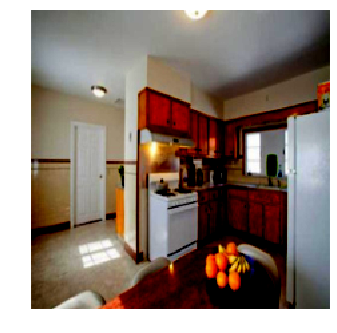

In [230]:
#visualize 1 image
datapoint = cocoData[1]
image, target = datapoint
#print(image.shape)
img = np.transpose(image, [1,2,0])
#print(target)

plt.imshow(img); plt.axis('off')
#cocoData.coco.showAnns(target)

In [191]:
#print categories in the supercategories of interest
cats = (cocoData.coco).loadCats((cocoData.coco).getCatIds())

for cat in cats:
  if (cat['supercategory'] == 'person' or cat['supercategory']=='vehicle' or cat['supercategory']=='animal'):
    print(cat['name'])
  #print("Super Catergories: ")
  #print(cat['supercategory'])
 

person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe


In [0]:
#returns the img dictionary and corresponding annotation id dictionary 
#containing images of
#the classes of interest (string sepcification, not id)
def generateSelImgDict(coco, interestSuperCats):
  #all categories
  #cats = coco.loadCats(coco.getCatIds())
  
  #category id's for the super categories of interest
  interestCatIds = coco.getCatIds(supNms = interestSuperCats)
  
  #the categories ids interest
  #they have a sueprcategory of 
  #person, vehicle or animal
  catIds_ = []
  imgIds = []
  annIds = []
  annDict = []
  
  #for all categories of interest, extract images with at least one of the 
  #categories in them
  for catId in interestCatIds:
        #catId = cocoData.coco.getCatIds(catNms = cat['name'])
        
        #get all images with at least this category in it
        imgIdVec = (cocoData.coco).getImgIds(catIds=catId)
        
        #for each image, add them to the id list
        #along with its annotations - this will allow easier access later on
        for item in imgIdVec:
          imgIds.append(item)
          
          #the ids for the annotation for this image, but only for the categories of
          #interest
          annId = cocoData.coco.getAnnIds(imgIds = item, catIds=interestCatIds, iscrowd=None)
          annDict.append(cocoData.coco.loadAnns(annId))

  #create dictionary of images of interest
  imgDict = (cocoData.coco).loadImgs(imgIds)
  
  return imgDict,annDict


In [0]:
supCatInterest = ['person', 'vehicle', 'animal']

In [0]:
#create the image and annotation dictionaries from the data
imgDict,annDict = generateSelImgDict(cocoData.coco, supCatInterest)

In [195]:
print(len(annDict))

5440


Height is: 480, Width is: 640


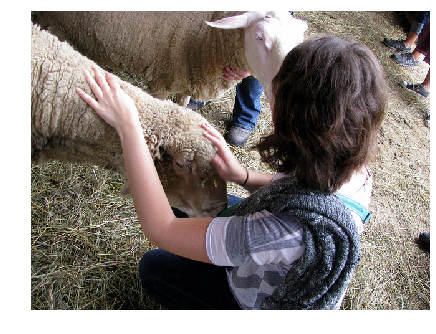

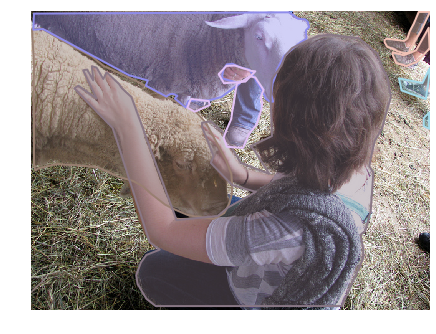

In [238]:
#Code adapted from:
#https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
#example image from those chosen

#example image
imgInd = 1

img  = imgDict[imgInd]
print("Height is: {}, Width is: {}".format(img['height'], img['width']))
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

#mask of image
plt.imshow(I); 
plt.axis('off')
#catIds = cocoData.coco.getCatIds(catNms= ['person', 'bus', 'bird', 'elephant'])
#annsId = cocoData.coco.getAnnIds(imgIds = img['id'], catIds = catIds, iscrowd = None)
#anns = cocoData.coco.loadAnns(annsId)
cocoData.coco.showAnns(annDict[imgInd])

(-0.5, 639.5, 479.5, -0.5)

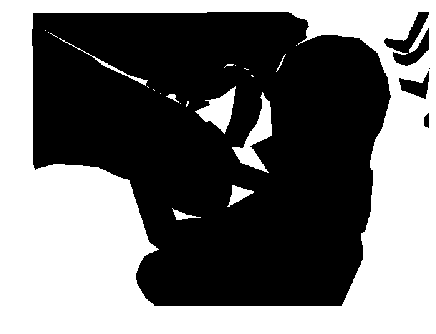

In [0]:
#bit mask for objects in image
#(objects of the category of interest)
anns = annDict[imgInd]
mask = cocoData.coco.annToMask(anns[0])

#create conglomerate mask over all objects in image
for i in range(len(anns)):
  mask = mask | cocoData.coco.annToMask(anns[i])

plt.imshow(mask); plt.axis('off')

In [0]:
print(mask)
mask_ = np.array(mask, dtype = 'float64')
print(mask_)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
#extract masked objects
#returns modified image
def extractWithMask(img,mask):
  mask_ = np.array(mask)
  
  #reshape to give 3rd axis for broadcasting
  #to the 3 channels
  mask_ = np.expand_dims(mask_, axis = 2)
  img_ = np.array(img)
  
  modified_image = img_*mask_
  
  return modified_image

(-0.5, 639.5, 479.5, -0.5)

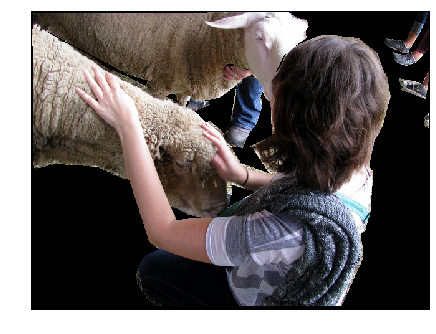

In [0]:
modified_img = extractWithMask(I, mask)
plt.imshow(modified_img)
plt.axis('off')

In [0]:
#given a single object's mask
#finds the percent of image that
#object occupies
def getPercentMask(obj_mask):
  num_occ= 0.0
  num_occ += (obj_mask != 0).sum()
  num_tot = sum(len(item) for item in obj_mask)
  
  return num_occ/num_tot


In [0]:
#given annotations for object
#creates a mask of only up to 4 prominent objects
#in the image
def genBinaryProminentMask(anns):
  mask = np.zeros(np.array(cocoData.coco.annToMask(anns[0])).shape)
  masks = []
  count = 0
  
  #order the annotations by percentage mask
  for i in range(len(anns)):
    obj_mask = cocoData.coco.annToMask(anns[i])
    percent = getPercentMask(obj_mask)
    masks.append((percent, obj_mask))
    
  #sort by percentage occupied
  masks.sort(key = itemgetter(0), reverse = True)
  
  #check if there exists a prominent object
  largest = masks[0][0]
  #print(largest)
  #return the empty mask if not prominent objects
  if(largest < PROMINENT_PERCENT_THRESHOLD):
    #print("Not large enough!")
    return mask
  
  #extract only the relevant masks
  #since we have at least 1 prominent objects
  #there can be smaller auxilary objects
  masks_filtered = [mask_[1] for mask_ in masks if mask_[0]>= OTHER_OBJ_THRESH]
    
  for i in range(len(masks_filtered)):
    if (count == MAX_PROMINENT_NUM):
      break
    
    mask += masks_filtered[i]
    count+=1
  
  #clip to form a binary mask
  mask = np.clip(mask, a_min = 0, a_max = 1)
  
  #count overall percentage
  #we want images which have some background
  all_percent = getPercentMask(mask)
  
  #if its too large, zero out mask
  if (all_percent > MAX_PERCENT):
    return mask*0
  
  return mask

(-0.5, 639.5, 479.5, -0.5)

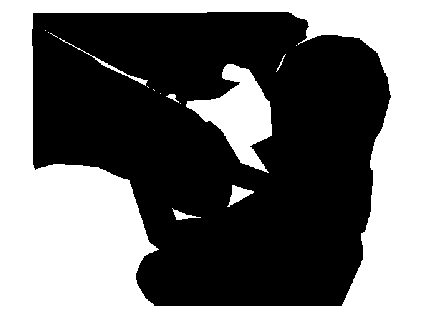

In [484]:
#test the code above on the img before
#only the man's object should be extracted in the mask now
mask_modified = genBinaryProminentMask(annDict[imgInd])
#print(mask_modified)
plt.imshow(mask_modified); plt.axis('off')

In [0]:
#given an img, crops and resizes it
#to be resize_dim by resize_dim
#fixes aspect ratio by padding to square
def crop_resize_square(img, mask, resize_dim=224):
  img = np.array(img)
  mask = np.array(mask)
  
  #turn img into a PIL img
  im_pil = Image.fromarray(img, 'RGB')
  mask_im = Image.fromarray(np.uint8(255*mask)) 

  #to make square, choose dimension for padding first
  #side_len = max(height, width, resize_dim)
  
  #maintain aspect ratio and reduce to a dimension of resize_dim
  size = (resize_dim, resize_dim)
  
  im = im_pil.copy()
  msk = mask_im.copy()
  
  #copy image and corresponding mask into lower size
  im.thumbnail(size,Image.ANTIALIAS)
  msk.thumbnail(size, Image.ANTIALIAS)
  
  w,h = im.size
  
  #create new image with black background
  square_im = Image.new('RGB', (resize_dim, resize_dim), (0,0,0))
  square_msk = Image.new('1', (resize_dim, resize_dim))#, (0,0,0))
  
  #paste in the original image to the square shaped one
  square_im.paste(im, (int((resize_dim-w)/2), int((resize_dim-h)/2)))
  square_msk.paste(msk, (int((resize_dim-w)/2), int((resize_dim-h)/2)))
  
  sq_msk_np = np.array(square_msk)
  sq_msk_np = np.clip(sq_msk_np, a_min=0, a_max=1)
  
  
  return np.array(square_im), sq_msk_np

(-0.5, 223.5, 223.5, -0.5)

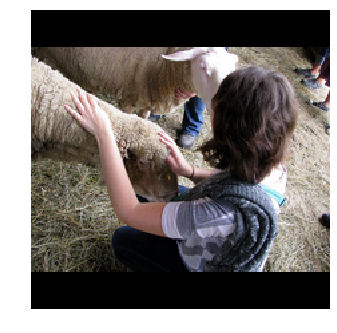

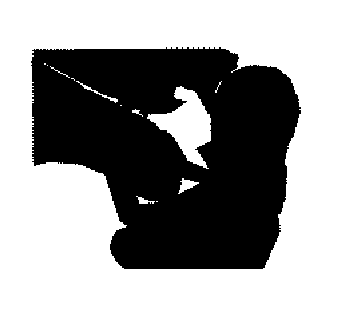

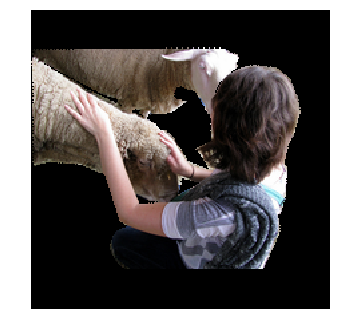

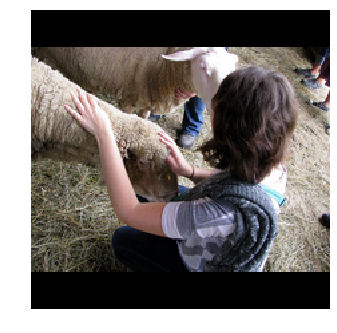

In [534]:
im,msk =crop_resize_square(I, mask_modified)
plt.figure()
plt.imshow(im); plt.axis('off')

plt.figure()
plt.imshow(msk); plt.axis('off')

plt.figure()
plt.imshow(extractWithMask(im, msk)); plt.axis('off')

plt.figure()
tensor = torch.from_numpy(im)
mask = torch.from_numpy(msk)
plt.imshow(tensor); plt.axis('off')

In [0]:
#given the img and annotation dictionaries
#removes and cleans the data
#so that only those images with
#prominent objects remain

#returns the cleaned images, and their masks
#as targets in a tuple called data

#returns a numpy array for image and mask
def data_parse_prominent(imgDict, annDict, size, crop = True, toTensor = False, path = "None"):
  
  data = []
  
  count = 0
  
  #randomly shuffle indices to 
  #acces different images
  ind = np.arange(len(imgDict))
  #random.shuffle(ind)
  
  for i in ind:
    
    #stop when size is reached
    if(count == size):
      break
      
    #generate prominent mask for object:
    mask = genBinaryProminentMask(annDict[i])
    
    #if entire mask is 0
    #there were no prominent objects in the mask
    #we only wish to add prominent objects
    if np.sum(mask)!=0:
      imgInf = imgDict[i]
      img = np.array(io.imread(imgInf['coco_url']))
     
      
      if (crop==True):
        img,mask = crop_resize_square(img, mask)
      
      if (toTensor == True):
        #transpose to [C,H,W] format for convolution
        img = torch.from_numpy(np.transpose(img, [2,0,1]))
        #img = img.float()
        
        mask = torch.from_numpy(mask).unsqueeze(0)
        #mask = mask.float()
      
      data.append((img, mask))
      count+=1
      
  if (count != size):
    print("Not enough data for size requested")
    
  return data

In [0]:
print(len(imgDict))

5440


In [0]:
data = data_parse_prominent(imgDict, annDict,20, toTensor = True)

In [0]:
data = data_parse_prominent(imgDict, annDict, 20)

In [250]:
print(len(data))

20


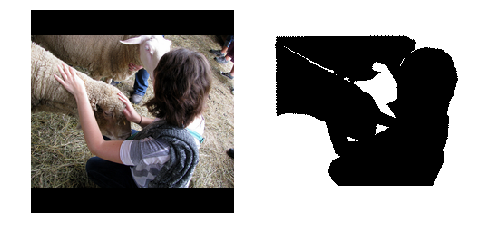

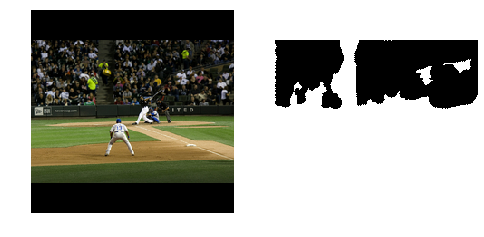

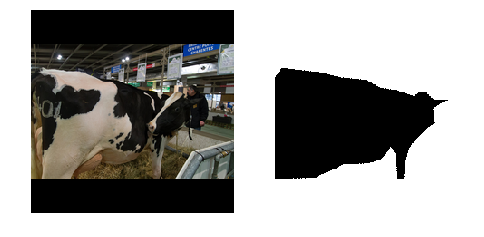

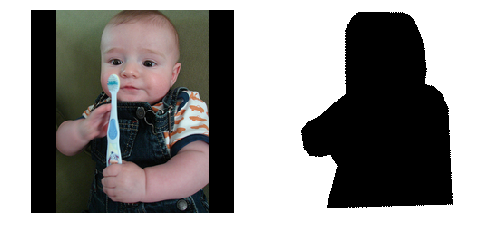

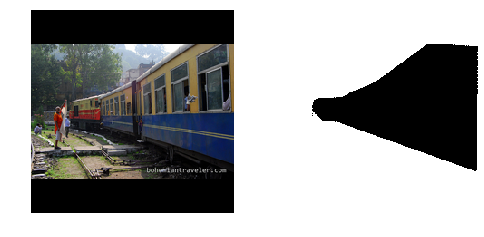

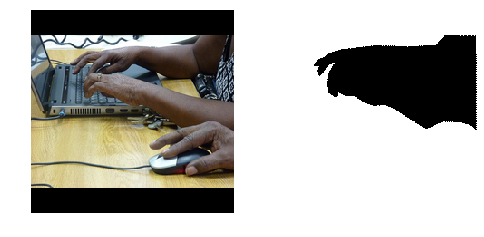

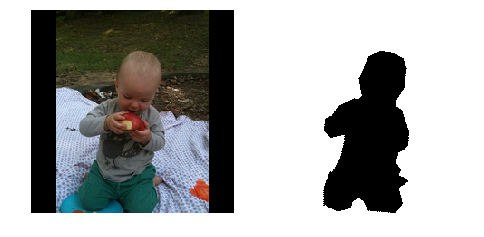

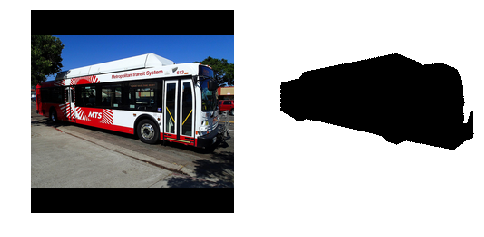

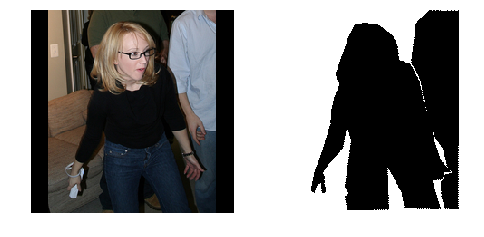

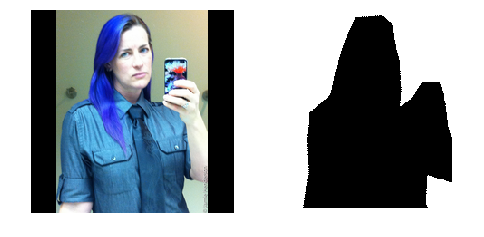

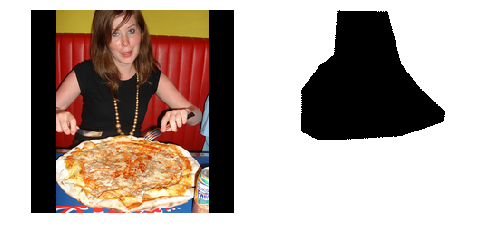

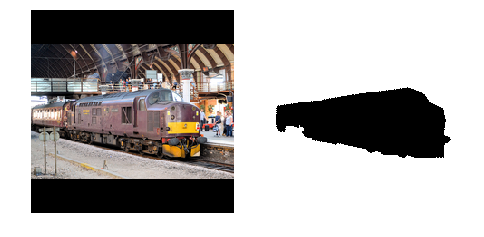

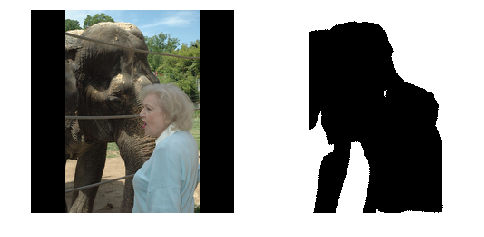

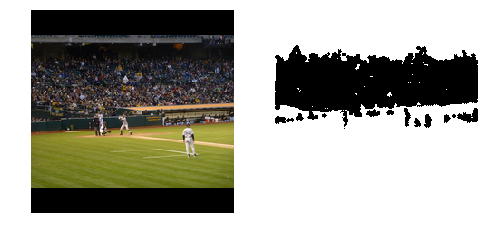

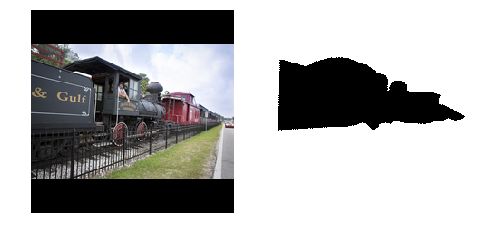

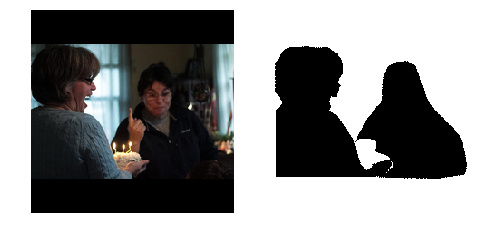

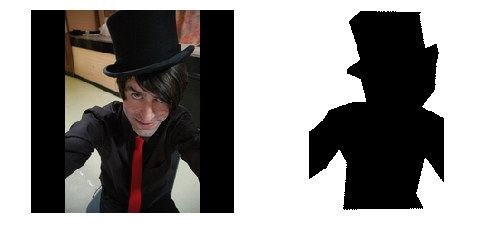

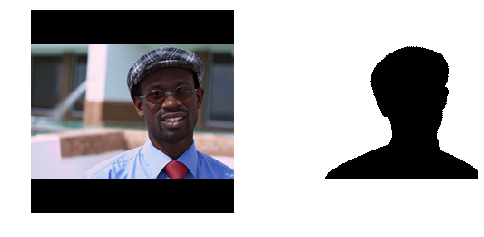

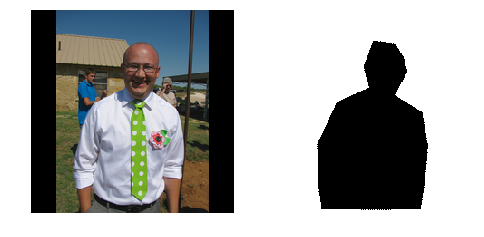

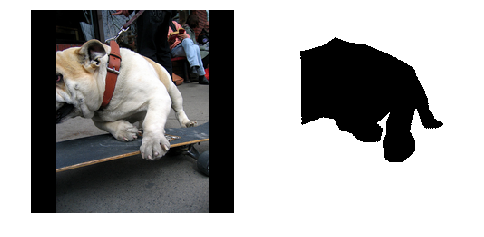

In [296]:
#visualization of data
for i,datapt in enumerate(data2):
  img, target = datapt
  
 # print("Image: {}".format(i))
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(img);   plt.axis('off')
  
  plt.subplot(1,2,2)
  plt.imshow(target); plt.axis('off')
  
plt.show()

In [0]:
data_loader =  torch.utils.data.DataLoader(data,
                                          batch_size=4,
                                          shuffle=True)

In [319]:
for i, data in enumerate(data_loader):
  if (i>10):
    break
    
  img, target = data
  print(img.shape)
  print(target.shape)
  

torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])


In [0]:
#create small dataset for training and validation
dataset = data_parse_prominent(imgDict, annDict,50, toTensor=True)
train = dataset[:40]
valid = dataset[40:]

In [0]:
train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=1,
                                          shuffle=False)

In [0]:
class extractNet_simple(nn.Module):
  
  def __init__(self):
    super(extractNet_simple, self).__init__()
    self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
    )
    self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
     )
  def forward(self, img):
        out = self.encoder(img)
        out = self.decoder(out)
        return out
  

In [0]:
net = extractNet_simple()

In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

Loss is:  tensor(0.2371, grad_fn=<BinaryCrossEntropyBackward>)
So far:  0
Loss is:  tensor(0.2346, grad_fn=<BinaryCrossEntropyBackward>)
So far:  1
Loss is:  tensor(0.2320, grad_fn=<BinaryCrossEntropyBackward>)
So far:  2
Loss is:  tensor(0.2301, grad_fn=<BinaryCrossEntropyBackward>)
So far:  3
Loss is:  tensor(0.2272, grad_fn=<BinaryCrossEntropyBackward>)
So far:  4
Loss is:  tensor(0.2233, grad_fn=<BinaryCrossEntropyBackward>)
So far:  5
Loss is:  tensor(0.2188, grad_fn=<BinaryCrossEntropyBackward>)
So far:  6
Loss is:  tensor(0.2141, grad_fn=<BinaryCrossEntropyBackward>)
So far:  7
Loss is:  tensor(0.2088, grad_fn=<BinaryCrossEntropyBackward>)
So far:  8
Loss is:  tensor(0.2030, grad_fn=<BinaryCrossEntropyBackward>)
So far:  9
Loss is:  tensor(0.1967, grad_fn=<BinaryCrossEntropyBackward>)
So far:  10
Loss is:  tensor(0.1901, grad_fn=<BinaryCrossEntropyBackward>)
So far:  11
Loss is:  tensor(0.1830, grad_fn=<BinaryCrossEntropyBackward>)
So far:  12
Loss is:  tensor(0.1754, grad_fn=<B

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss is:  tensor(0.0005, grad_fn=<BinaryCrossEntropyBackward>)
So far:  999


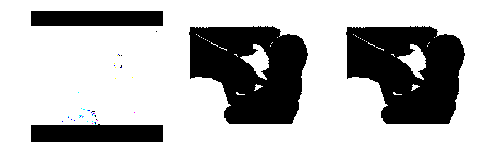

In [501]:
max_j = 999

for j in range(max_j+1):
  for i, data in enumerate(train_loader):
    if (i>0):
      break
    
    img, target = data
    out = net(img[0].unsqueeze(0))
    loss = criterion(out[0], target[0])
    loss.backward() 
    optimizer.step()
    optimizer.zero_grad()
    
    if(j == max_j):
      plt.figure()
      plt.subplot(1,3,1)
      plt.imshow(to_np_img(img[0]));   plt.axis('off')
  
      plt.subplot(1,3,2)
      plt.imshow(to_np_img(target[0])); plt.axis('off')
  
      plt.subplot(1,3,3)
      generatedMask = threshold_prob_mask(to_np_img(out[0]))
  
  
      plt.imshow(generatedMask); plt.axis('off')

    print("Loss is: ", loss)
  
  
  print("So far: ", j)
 

(-0.5, 223.5, 223.5, -0.5)

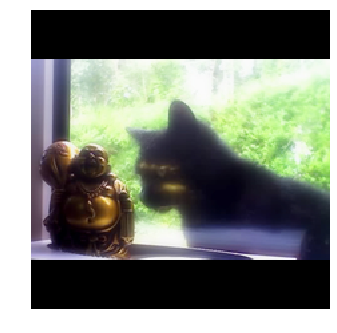

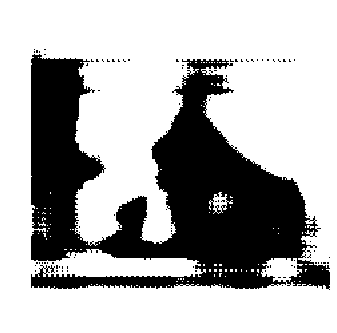

In [557]:
img, target = train[-12]

plt.figure()
plt.imshow(to_np_img(img)); plt.axis('off')

res = net(img.unsqueeze(0).float())

plt.figure()
mask_p = threshold_prob_mask(to_np_img(res[0]))
plt.imshow(mask_p.squeeze()); plt.axis('off')

In [0]:
#given a tensor of images, converts to numpy images
#assumes tensor image is in format NCHW
def to_np_img(tensor_img):
  image = tensor_img.detach().numpy()
  
  #print("This dimensions is: ", image.shape)
  image = np.transpose(image, [1,2,0])
  return image.squeeze()

def threshold_prob_mask(prob_mask):
  prob_mask[prob_mask>0.5] = 1
  prob_mask[prob_mask<=0.5] = 0
  return prob_mask

In [0]:
#training helper functions


In [0]:
supCatInterest = ['person']

#create the image and annotation dictionaries from the data
imgDict,annDict = generateSelImgDict(cocoData.coco, supCatInterest)

#create small dataset for training and validation
dataset = data_parse_prominent(imgDict, annDict,50, toTensor=True)
train = dataset[:40]
valid = dataset[40:]